In [13]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
from collections import defaultdict

In [8]:
predictions_file = open('postprocessing/clf_TEST_out.csv', newline='')
predictions_reader = csv.reader(predictions_file, delimiter=',')
predictions = []
for e in predictions_reader:
    predictions.append(e)

In [15]:
rate = 24000
increment = 1.0/rate
pred_dict = defaultdict(list)
pred_dict_array = {}

for i in range(1,len(predictions)):
    pred_dict[predictions[i][0]].append([predictions[i][1], predictions[i][2]])
    
for key in tqdm(pred_dict.keys()):
        
    #Go from onset offset predictions to array with binary elements indicating events
    index = 0.0
    prediction_array = []
    for event in pred_dict[key]:
        while index < float(event[0]):
            prediction_array += [0]
            index += increment
        while index < float(event[1]):
            prediction_array += [1]
            index += increment
    
    pred_dict_array[key] = prediction_array

100%|███████████████████████████████████████████| 31/31 [00:55<00:00,  1.80s/it]


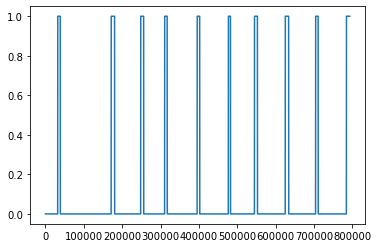

In [17]:
plt.plot(pred_dict_array[list(pred_dict_array.keys())[0]][600000:])